## Lista 5 - Aprendizagem de Máquina Probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cholesky
import matplotlib.pyplot as plt

## Modelos

### Inferência com modelos de GP para regressão 
- Estimação 

    1. Inicializar hiperparâmetros $\theta = \big[  \sigma^2_f, w^2_1, \cdots, w^2_D, \sigma^2_y \big]^T$

    2. Repetir até convergir ou número de épocas

        1. Calcular a evidência do modelo $\log p(y|X, \theta)$. A evidência é calculada via Cholesky.
            $$K+ \sigma^2_y = LL^T, \alpha = L^{-1}y$$
            $$\mathcal{L} (\theta) = - \sum_{i}{\log L_{ii} - \frac{1}{2} \alpha^T \alpha - \frac{N}{2} \log (2 \pi)}$$
        2. Calcular os gradientes analíticos $\frac{\partial \log p(y|X, \theta)}{\partial \theta}$.
        3. Atualizar $\theta$ a partir dos gradientes.

    3. Retornar os hiperparâmetros

- Predição

1. Dado um novo padrão $x_\ast$ retornar a distribuição preditiva 

$$p(y| x_\ast, y, X, \hat{\theta}) = \mathcal{N}(y_\ast| \mu_\ast, \sigma^2_\ast + \sigma^2_y)$$

$$\mu_\ast = k_{f \ast}^T (K + \sigma^2_y I)^{-1} y$$

$$\sigma^2_\ast = k_{\ast \ast} - k_{f \ast}^T (K + \sigma^2_y I)^{-1} k_{f \ast}$$

Em que, $k_{f \ast} = [k(x_\ast, x_1), \cdots , k(x_\ast, x_N)]$ e $k_{\ast \ast} = k(x_\ast, x_\ast)$

Além disso, valores de inicialização comuns são, $\sigma^2_f = \mathbb{V}[y]$, $w^2_d = \frac{1}{\mathbb{V}[X_{:d}]}$ e $\sigma^2_y = 0.01 \sigma^2_f$, com o $\mathbb{V}$ sendo a variância.


In [ ]:
class RegGP:
    def __init__(self, sigma2f, w0, sigma2y):
        sigma2f = float(sigma2f)
        w0 = float(jnp.asarray(w0).reshape(()))
        sigma2y = float(sigma2y)

        self.theta = jnp.array([jnp.log(sigma2f), jnp.log(w0), jnp.log(sigma2y)], dtype=jnp.float32)

    def unpack(self, theta):
        sigma2f = jnp.exp(theta[0])
        w = jnp.exp(theta[1:-1]) 
        sigma2y = jnp.exp(theta[-1])
        return sigma2f, w, sigma2y

    def RBF(self, theta, xi, xj):
        sigma2f, w, _ = self.unpack(theta)
        diff = xi - xj
        temp = jnp.sum(w * diff**2)
        return sigma2f * jnp.exp(-0.5 * temp)

    def apply_kernel(self, theta, X):
        return jax.vmap(lambda xi:
                        jax.vmap(lambda xj: self.RBF(theta, xi, xj))(X)
                        )(X)

    def evidence(self, theta, X, y, jitter=1e-6):
        sigma2f, w, sigma2y = self.unpack(theta)
        N = y.shape[0]

        K = self.apply_kernel(theta, X)
        K_y = K + (sigma2y + jitter) * jnp.eye(N)

        L = cholesky(K_y)
        alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, y))

        quad = 0.5 * (y.T @ alpha)
        logdet = jnp.sum(jnp.log(jnp.diagonal(L)))
        log_evid = - quad - logdet - 0.5 * N * jnp.log(2 * jnp.pi)

        return jnp.squeeze(log_evid)

    def predict(self, X_ast):
        theta = self.theta
        sigma2f, w, sigma2y = self.unpack(theta)

        X = self.X
        y = self.y
        N = X.shape[0]

        K = self.apply_kernel(theta, X)
        jitter = 1e-6
        K_y = K + (sigma2y + jitter) * jnp.eye(N)

        kf = jax.vmap(lambda xast:
                      jax.vmap(lambda x: self.RBF(theta, xast, x))(X)
                      )(X_ast)       
        
        k_ast_ast = jax.vmap(lambda xast: self.RBF(theta, xast, xast))(X_ast)  

        alpha = jnp.linalg.solve(K_y, y)        
        mu = kf @ alpha                         

        v = jnp.linalg.solve(K_y, kf.T)          
        sigma2 = k_ast_ast - jnp.sum(v * kf.T, axis=0)
        sigma2 = jnp.maximum(sigma2, 1e-9)

        return mu.squeeze(), sigma2.squeeze()

    def estimate(self, X_train, y_train, epochs=200, lr=1e-3,
                 grad_clip=100.0, jitter=1e-6):

        self.X = jnp.asarray(X_train)
        self.y = jnp.asarray(y_train)

        def obj(theta):
            return self.evidence(theta, self.X, self.y, jitter=jitter)

        val_and_grad = jax.value_and_grad(obj)
        theta = self.theta

        for epoch in range(epochs):
            val, grads = val_and_grad(theta)

            grads = jnp.nan_to_num(grads, nan=0.0, posinf=1e6, neginf=-1e6)
            grads = jnp.clip(grads, -grad_clip, grad_clip)

            theta = theta + lr * grads

        self.theta = theta
        return theta


## Métricas
$$RMSE = \sqrt{\frac{\sum_{i = 1}^{N_{teste}} (y_i - \hat{y_i})^2}{N}}$$
$$NLPD = \frac{1}{2} \log 2 \pi + \frac{1}{2N_{teste}} \sum^{N_{teste}}_{i=1} \big [ \log \hat{\sigma_i}^2  + \frac{(y_i- \hat{\mu_i})^2}{\hat{\sigma}_i^2}\big]$$


In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def NLPD(y_true, pred_var, pred_mean):
    eps = 1e-9
    pred_var = pred_var + eps
    term = np.log(pred_var) + (y_true - pred_mean)**2 / pred_var
    return 0.5*np.log(2*np.pi) + 0.5 * np.mean(term)

## Questão 1

In [ ]:
def plot_predictions(X_train, y_train, X_test, mu, var, title):
    sigma = np.sqrt(var)

    plt.figure(figsize=(8,5))

    # média
    plt.plot(X_test, mu, label="Predição (media)", linewidth=2)

    # intervalo mu + 2 desvios padrao
    plt.fill_between(
        X_test.flatten(),
        (mu - 2*sigma).flatten(),
        (mu + 2*sigma).flatten(),
        alpha=0.3,
        label="Incerteza (±2 desvio padrao)"
    )

    # pontos de treino
    plt.scatter(X_train, y_train, c="black", s=20, label="Treino")

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


In [ ]:
def treinao(N_values, train_file, test_file, epochs=200, lr=0.01):

    # carregar CSV
    train = np.loadtxt(train_file, delimiter=",")
    test = np.loadtxt(test_file, delimiter=",")

    X_train_full = train[:,0:1]
    y_train_full = train[:,1:2]

    X_test = test[:,0:1]
    y_test = test[:,1:2]

    results = {}

    for N in N_values:
        print(f"Treinando com N = {N}")

        # selecionar primeiros N dados
        X_train = X_train_full[:N]
        y_train = y_train_full[:N]

        # inicialização padrão
        sigma2f = np.var(y_train)
        w0 = float(1.0 / np.var(X_train))
        sigma2y = 0.01 * sigma2f

        gp = RegGP(sigma2f, w0, sigma2y)

        # treinar GP
        gp.estimate(X_train, y_train, epochs=epochs, lr=lr)

        # predições
        mu_train, var_train = gp.predict(X_train)
        mu_test, var_test = gp.predict(X_test)

        # métricas
        rmse_train = RMSE(y_train, mu_train)
        rmse_test  = RMSE(y_test,  mu_test)

        nlpd_train = NLPD(y_train, var_train, mu_train)
        nlpd_test  = NLPD(y_test,  var_test,  mu_test)

        print(f"RMSE treino: {rmse_train:.4f}")
        print(f"RMSE teste : {rmse_test:.4f}")
        print(f"NLPD treino: {nlpd_train:.4f}")
        print(f"NLPD teste : {nlpd_test:.4f}")

        # salvar resultados
        results[N] = {
            "rmse_train": rmse_train,
            "rmse_test": rmse_test,
            "nlpd_train": nlpd_train,
            "nlpd_test": nlpd_test
        }

        # plot curva predita
        xt = np.linspace(-1, 1, 200).reshape(-1,1)
        mu_plot, var_plot = gp.predict(xt)

        plot_predictions(
            X_train, y_train,
            xt, mu_plot, var_plot,
            title=f"GP com N={N}"
        )


    return results


Treinando com N = 10
RMSE treino: 0.6054
RMSE teste : 0.5418
NLPD treino: 19.8934
NLPD teste : 8.2211


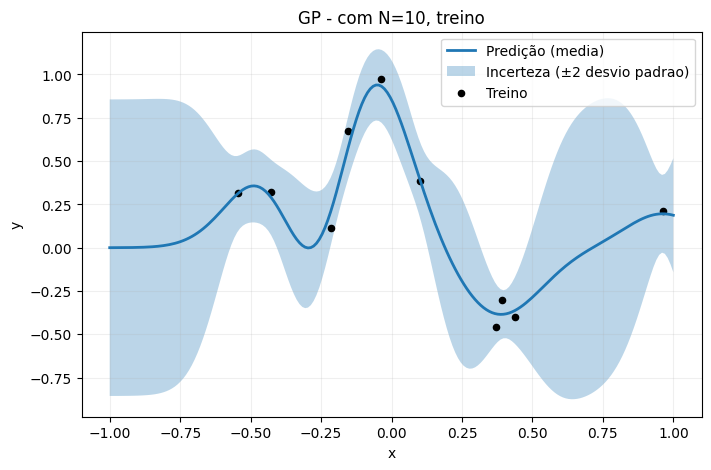

Treinando com N = 30
RMSE treino: 0.6147
RMSE teste : 0.5978
NLPD treino: 53.6285
NLPD teste : 34.4144


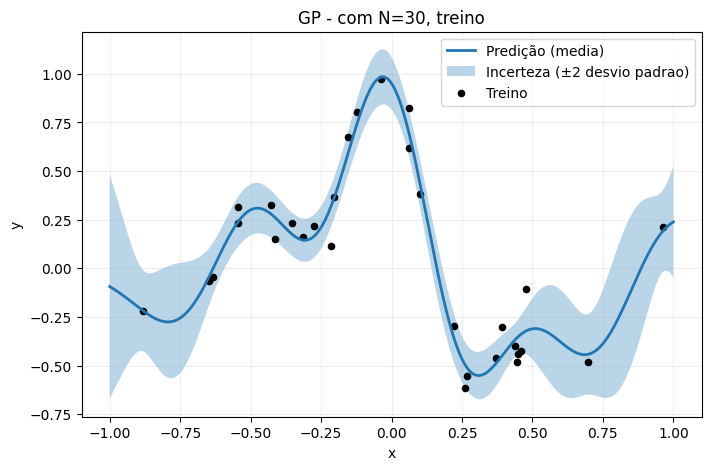

Treinando com N = 50
RMSE treino: 0.6657
RMSE teste : 0.5971
NLPD treino: 93.3805
NLPD teste : 57.6647


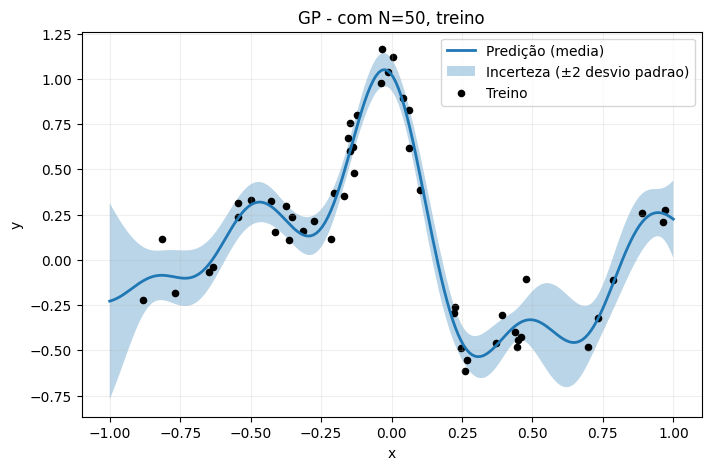

Treinando com N = 75
RMSE treino: 0.6739
RMSE teste : 0.6051
NLPD treino: 152.6376
NLPD teste : 103.2866


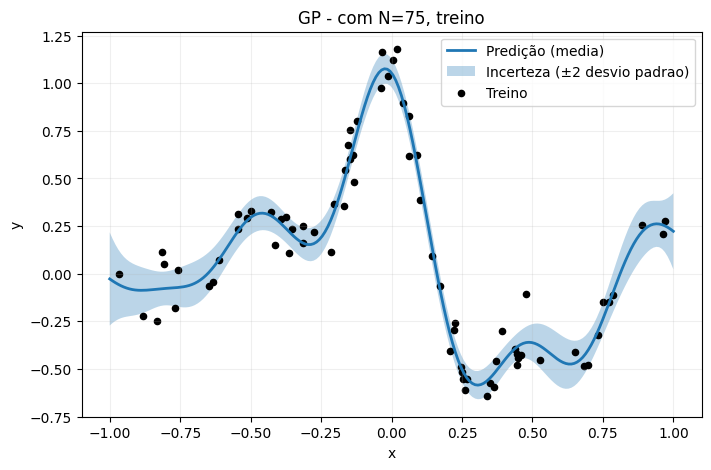

Treinando com N = 100
RMSE treino: 0.6232
RMSE teste : 0.6009
NLPD treino: 161.6875
NLPD teste : 128.5297


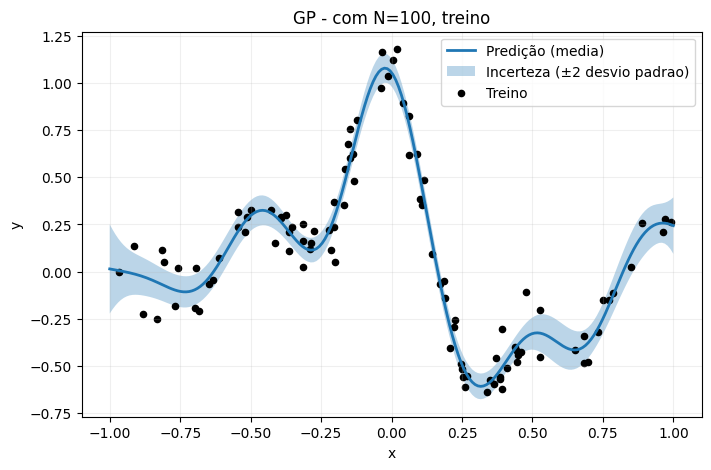

In [ ]:
results = treinao(
    N_values=[10, 30, 50, 75, 100],
    train_file="gp_data_train.csv",
    test_file="gp_data_test.csv",
    epochs=300,
    lr=0.01
)
